# Getting Started with VSPEC

#### This tutorial will go through a basic use case for VSPEC

The first step is to load our model parameters. This is done with a configuration file.

In [1]:
from VSPEC import ObservationModel
import matplotlib.pyplot as plt
from astropy import units as u

CONFIG_FILENAME = 'basics.cfg'

Let's look at the contents of this config file

In [10]:
with open(CONFIG_FILENAME, 'r') as file:
    for i in range(20): #read the first 20 lines
        print(file.readline(),end='')
    print('...')

# Config file uses Proxima Centauri and Proxima Centauri-b as an example case.

# This section outlines the parameters necessary to create the variable star
[Star]

# Name of this star; program creates a folder for it and all the data/images/graphs produced
# Make it unique from previous runs/defaults included in the repository.
star_name = vspec_basics

# quiet photosphere teff in K
star_teff = 3300

# minimum teff to bin
star_teff_min = 2300
# maximum teff to bin
star_teff_max = 3400

limb_darkening_a1 = 0.93
limb_darkening_a2 = -0.23

...


The config file provides almost all the information necessary to run VSPEC. Additionally, the user must supply a Global Circulation Model (GCM) that is compatable with PSG. In our case, the config file points to `modernearth.gcm` which contains this data.

We will initialize our model with the config.

In [11]:
model = ObservationModel(CONFIG_FILENAME)

There is now a directory structure in `$CWD`:
```
.
|____vspec_basics
| |____Data
| | |____PSGLayers
| | |____PSGThermalSpectra
| | |____PSGConfig
| | |____PSGNoise
| | |____binned_data
| | |____AllModelSpectraValues
| | |____PSGCombinedSpectra
```
Running the model will populate these various subdirectories

The next step is to load the spectra. This must be done the first time a model is initialized in a particular directory. VSPEC comes with a grid of high-resolution stellar spectra that must be binned to fit the instrumental parameters defined in `basics.cfg`. These spectra are stored in the `binned_data` folder to be quickly recalled in the future.

Rerun this command if you change the wavelength range or resolving power in `basics.cfg`

In [12]:
model.bin_spectra()

Binning Spectra:   0%|          | 0/12 [00:00<?, ?it/s]

Now that we have everything set up, we can generate the planet spectra. We will use an API to call the Planetary Spectrum Generator (PSG, [psg.gsfc.nasa.gov](psg.gsfc.nasa.gov)). It is recommended that each user install their own local version of PSG, but it is possible to run VSPEC with a PSG API key. Follow the instructions in the PSG manual to install locally using docker and rancher desktop (required for non-Linux systems). It is among the easiest codes to install.

In the command line, start your local PSG with `docker start psg`

Then our model will make a seriese of API calls and download the outputs.

In [13]:
model.build_planet()

Starting at phase 180.0 deg, observe for 10.0 d in 20 steps
Phases = [180.   198.95 217.89 236.84 255.79 274.74 293.68 312.63 331.58 350.53
   9.47  28.42  47.37  66.32  85.26 104.21 123.16 142.11 161.05 180.  ] deg


Build Planet:   0%|          | 0/20 [00:00<?, ?it/s]

How did the model know how many steps to use or what the planet phase should be at each step?

`basics.cfg` defines the system geometry, observation parameters, and initial conditions. These are all fed into the `VSPEC.geometry` module, which computes all the angles that define the system at each time step. Learn more in our [geometry tutorial]().

Let's now run the stellar model. We will generate stellar spectra at each time step and integrate it with the planet spectrum. Because the star can change quickly and the spectra are generally less expensive to generate than the planet, we can use a shorter cadence. In this case, the planet spectrum is interpolated.

In [14]:
model.build_spectra()

Generated 41 mature spots


Build Spectra:   0%|          | 0/480 [00:00<?, ?it/s]

That's it! We have sucessfully simulated an observation with VSPEC. To learn more about the star, see our [variable star tutorial]().

All the data is stored in `vspec_basics/Data/AllModelSpectraValues/`. These are `csv` files describing the system at each time step. `VSPEC` provides some functionality to read these files and perform some analysis. Let's read in the data we just created.

In [2]:
from VSPEC import PhaseAnalyzer

data = PhaseAnalyzer('vspec_basics/Data/AllModelSpectraValues/')

A 2D fluxmap of each component in our observation can be accessed as attributes of `data`. For example, `data.thermal` gives an array representing the thermal flux of the planet (also try `reflected`, `star`, `total`, `noise`). 

Text(0, 0.5, 'wavelength (um)')

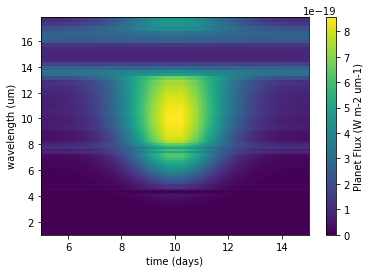

In [3]:
plt.pcolormesh(data.time.to(u.day).value,data.wavelength.value,
            data.thermal.value)
plt.colorbar(label='Planet Flux (W m-2 um-1)')
plt.xlabel('time (days)')
plt.ylabel('wavelength (um)')

We can plot the lightcurve of a particular pixel using the `lightcurve` method of `data`. We can use this to look at how our star varies with time.

Text(0, 0.5, 'total flux (W m-2 um-1)')

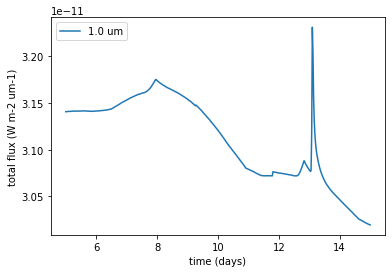

In [4]:
plt.plot(data.time.to(u.day),data.lightcurve('total',0),label = f'{data.wavelength[0]:.1f}')
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('total flux (W m-2 um-1)')

The `combine` method allows us to quickly plot spectra, including time-averaged spectra that improve SNR.

Text(0, 0.5, 'total flux (W m-2 um-1)')

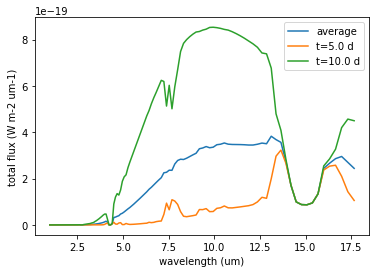

In [7]:
plt.plot(data.wavelength,data.combine('thermal',(0,-1)),label = 'average')
plt.plot(data.wavelength,data.combine('thermal',0),label = f't={data.time[0].to(u.day):.1f}')
plt.plot(data.wavelength,data.combine('thermal',240),label = f't={data.time[240].to(u.day):.1f}')
plt.legend()
plt.xlabel('wavelength (um)')
plt.ylabel('total flux (W m-2 um-1)')

Lots more can be down with this class. See the [analysis tutorial]() to learn more.